# Example Notebook Ship tracks from emissions maps

In [1]:
# importing libraries

import pickle

from modis_tools import delete_no_overlap, UngriddedData_from_data_frame
import glob
import calendar
from multiprocessing import Pool
import sys

from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import numba
import sys
import numpy as np
import pandas as pd
import xarray as xr
import trackpy as tp
import trackpy.diag

import numba

from pandas import DataFrame, Series  # for convenience
import time
import tables
import pims
import pickle
import trackpy as tp
from get_reanalysis import get_profile_data, get_uv_data

from cis.data_io.ungridded_data import UngriddedDataList
import os
os.environ['CIS_PLUGIN_HOME'] = '/home/users/pete_nut/plugins/'
from cis import read_data, read_data_list, get_variables
from modis_tools import delete_no_overlap, UngriddedData_from_data_frame
import glob
import datetime
import matplotlib.pyplot as plt
import time




## 0. Find the satellite datasets which overlap with the emissions data window

In [4]:
# We only have emissions data for a certain region, so we have to filter the modis tiles for this
# observation window


observation_window=[[-50., 50.],[ -90.,20.]]



def find_modis_granules_aqua(year, month, i):
    day=str(i+1).zfill(2)
    modis_dir = '/neodc/modis/data/MYD06_L2/collection61/{}/{}/{}/'
    modis_daily = sorted(glob.glob(modis_dir.format(year, month, day) + '*.hdf'))
    
    try: 
        end_day = glob.glob(modis_dir.format(year, month, day) + '*.2100.*.hdf')[0]
        end_day = modis_daily.index(end_day)
    except IndexError: end_day = -1 #glob.glob(modis_dir.format(year, month, day) + '*.2300.*.hdf')[0]
    # end_day = modis_daily.index(end_day)
    try: 
        start_time=glob.glob(modis_dir.format(year, month, day) + '*.0850.*.hdf')[0]
        start_time=modis_daily.index(start_time)
    except IndexError: 
        start_time=0 #glob.glob(modis_dir.format(year, month, day) + '*.0800.*.hdf')[0]    
    
    modis_daily = modis_daily[start_time:end_day]
    modis_daily=delete_no_overlap(modis_daily, observation_window)
    return modis_daily

def find_modis_granules_terra(year, month, i):
    day=str(i+1).zfill(2)
    modis_dir = '/neodc/modis/data/MOD06_L2/collection61/{}/{}/{}/'
    
    modis_daily = sorted(glob.glob(modis_dir.format(year, month, day) + '*.hdf'))
    try: 
        end_day = glob.glob(modis_dir.format(year, month, day) + '*.1800.*.hdf')[0]
        end_day = modis_daily.index(end_day)
    except IndexError: end_day = -1 #glob.glob(modis_dir.format(year, month, day) + '*.2000.*.hdf')[0]
    
    try: 
        start_time=glob.glob(modis_dir.format(year, month, day) + '*.0550.*.hdf')[0]
        start_time=modis_daily.index(start_time)
    except IndexError: start_time=0 #glob.glob(modis_dir.format(year, month, day) + '*.0500.*.hdf')[0]

    modis_daily = modis_daily[start_time:end_day]
    modis_daily=delete_no_overlap(modis_daily, observation_window)
    return modis_daily


In [5]:
year='2019'
index=8
months=['00','01','02','03','04','05','06','07','08','09','10','11','12']
month=months[index]


In [7]:
modis_list={'aqua':[],'terra':[]}

for i in range(calendar.monthrange(int(year), int(month))[1])[0:1]:
    print(i)
    modis_list['aqua'].append(find_modis_granules_aqua(year, month, i))
    modis_list['terra'].append(find_modis_granules_terra(year, month, i))

f = open("example_data/modis_swaths_intersect_{}_{}.pkl".format(year, month),"wb")
pickle.dump(modis_list,f)
f.close()

0


In [10]:
f

<_io.BufferedReader name='example_data/modis_swaths_intersect_2019_03.pkl'>

In [6]:
f = open("example_data/modis_swaths_intersect_{}_{}.pkl".format(year, month),"rb")
mo=pickle.load(f)
f.close()

In [15]:
#this is the list of MODIS files that have an overlap with the observation window on the given day
mo

{'aqua': [['/neodc/modis/data/MYD06_L2/collection61/2019/03/01/MYD06_L2.A2019060.0925.061.2019060193234.hdf',
   '/neodc/modis/data/MYD06_L2/collection61/2019/03/01/MYD06_L2.A2019060.1045.061.2019061174527.hdf',
   '/neodc/modis/data/MYD06_L2/collection61/2019/03/01/MYD06_L2.A2019060.1155.061.2019061180703.hdf',
   '/neodc/modis/data/MYD06_L2/collection61/2019/03/01/MYD06_L2.A2019060.1200.061.2019061180318.hdf',
   '/neodc/modis/data/MYD06_L2/collection61/2019/03/01/MYD06_L2.A2019060.1205.061.2019061180653.hdf',
   '/neodc/modis/data/MYD06_L2/collection61/2019/03/01/MYD06_L2.A2019060.1210.061.2019061180221.hdf',
   '/neodc/modis/data/MYD06_L2/collection61/2019/03/01/MYD06_L2.A2019060.1215.061.2019061175434.hdf',
   '/neodc/modis/data/MYD06_L2/collection61/2019/03/01/MYD06_L2.A2019060.1220.061.2019061175809.hdf',
   '/neodc/modis/data/MYD06_L2/collection61/2019/03/01/MYD06_L2.A2019060.1225.061.2019061180700.hdf',
   '/neodc/modis/data/MYD06_L2/collection61/2019/03/01/MYD06_L2.A2019060.1

## 1. Convert the maps of emissions into ship trajectories

In [8]:
# we get the emissions as 0.05 degree gridded maps, shown below

In [16]:
monthly_emis=xr.open_mfdataset('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/Emissions/'+year+'/SOx_*.nc', chunks={'latitude': 10, 'longitude': 10})
monthly_emis=monthly_emis.SOx.loc[year+'-'+month]

In [17]:
day_av=monthly_emis.sel(time=year+"-"+month+"-"+'01').mean(dim='time')

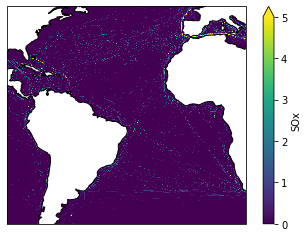

In [33]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

ax = plt.axes(projection=ccrs.PlateCarree())
day_av.plot( vmax=5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='white'))

# this shows the map of data that we work with: an hourly grid of emissions
# to extract individual ship trajectories, we will need to track the movement of emission peaks

In [9]:

# luckily, there is a library called trackpy for this

trackpy.diag.performance_report()

def x_coarse_to_lon(x):
    lon=x/20-90
    return lon
def y_coarse_to_lat(y):
    lat=50-y/20
    return lat


def track_emissions_coarse(i):
    if i+1<10: day='0{}'.format(i+1)
    else: day=str(i+1)
    
    # find features and trajectories
    print('working on day:', day, month, year)
    monthly_emis=xr.open_mfdataset('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/Emissions/'+year+'/SOx_*.nc', chunks={'latitude': 10, 'longitude': 10})
    monthly_emis=monthly_emis.SOx.loc[year+'-'+month]
    frames=monthly_emis
    f=tp.batch(frames[(int(day)-1)*24:int(day)*24].values, 7)

    #search_range argument as usual, along with an adaptive_stop argument, and optionally an adaptive_step.
    pred = tp.predict.NearestVelocityPredict()
    t = pred.link_df(f, search_range=20, adaptive_stop=4,adaptive_step=0.98,  memory=3)
    t1 = tp.filter_stubs(t,3)
    
    # Compare the number of particles in the unfiltered and filtered data.
    print('Before:', t['particle'].nunique())
    print('After:', t1['particle'].nunique())

    #clean up the dataset
    t1['hour']=pd.to_datetime(year+month+day)+pd.to_timedelta(t1.frame.values, unit='hours')
    t1['latitude']=y_coarse_to_lat(t1.y)
    t1['longitude']=x_coarse_to_lon(t1.x)
    t1=t1.set_index(t1['hour'])
    t1=t1.drop(columns=['hour','frame','size','ecc','raw_mass','ep']).sort_index()
    t1.to_csv('example_data/emissions_tracked/{}_{}_{}'.format(year, month, day))
  

Yes, but could it be faster?
FAST: numba is available and enabled (fast subnets and feature-finding).


In [10]:
# apply the above function with parallelisation

with Pool(16) as p:
        p.map(track_emissions_coarse, range(calendar.monthrange(int(year), int(month))[1])[0:1] )
        # if year=='2018': p.map(track_emissions, range(calendar.monthrange(int(year), int(month))[1]) )

working on day: 01 08 2019


Process ForkPoolWorker-15:
Process ForkPoolWorker-9:
Process ForkPoolWorker-8:
Process ForkPoolWorker-12:
Process ForkPoolWorker-14:
Process ForkPoolWorker-5:
Process ForkPoolWorker-10:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-13:
Process ForkPoolWorker-6:
Process ForkPoolWorker-11:
Process ForkPoolWorker-16:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/users/pete_nut/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent cal

In [11]:
import pandas as pd

lines=pd.read_csv('example_data/emissions_tracked/{}_{}_{}'.format(year, month, '01'))

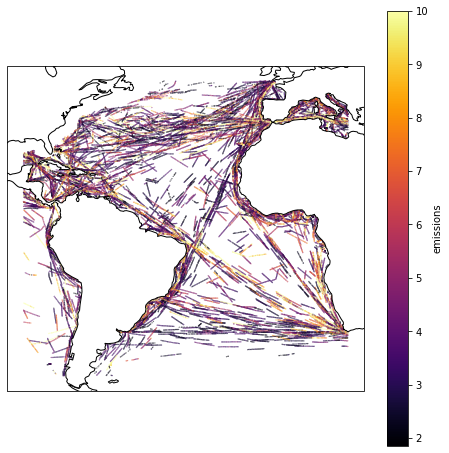

In [32]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(lines.longitude, lines.latitude, c=lines.signal, cmap='inferno', s=0.05, vmax=10)
plt.colorbar(label='emissions')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='white'))


In [34]:
# great, we have converted the emissions into trajectories
# now, we can continue by advecting them with the wind until the time that MODIS sees them

## 3. Advect with the wind

In [12]:

def create_hysplit_control_file_multi(year,month,day,hour,minute,lats,lons,MLHeight,trajHours,path,workingpath,metpath):

    nTraj = len(lats)
    print('YEAR: ',year)
    print('MONTH: ',month)
    print('DAY: ',day)
    print('HOUR: ',hour)
    print('MINUTE: ',minute)
    print('HYSPLIT Path: ',path)
    print('Number of trajectories: ',nTraj)
    #print('Height: ',MLHeight)
    #print('Longitude: ',lons)
    #print('Latitude: ',lats)
    
    #Fetch reanalysis files
    if metpath.find("RP") > 0:  #RP reanalysis path used
        metfiles = fetch_rp_reanalysis(month,year,metpath)

    if metpath.find("GDAS") > 0:  #GDAS reanalysis path used
        metfiles = fetch_gdas_reanalysis(day,month,year,metpath)

    if metpath.find("ERA5") > 0:  #ERA5 reanalysis path
        metfiles = fetch_era5_reanalysis(day,month,year,metpath,trajHours)
    
    if metpath.find("MERRA2") > 0:  #ERA5 reanalysis path
        metfiles = fetch_merra2_reanalysis(day,month,year,metpath,trajHours)
    
    nmetfiles = len(metfiles)
    
    #---------------------------------------------------------------
    # Create HYSPLIT CONTROL FILE
    #---------------------------------------------------------------
    fName = workingpath+'CONTROL'
    print('CONTROL FILE: ',fName)

    f = open(fName, 'w')
    f.writelines( str(year-2000).zfill(2)+' '+str(month).zfill(2)+' '+str(day).zfill(2)+' '+str(hour).zfill(2) +' '+str(minute).zfill(2)+"\n" ) #time
    f.writelines( str(nTraj) +"\n") #number of trajectories
    #starting location of each trajectory
    for i in range(nTraj):
        f.writelines("{:6.2f}".format((float(lats[i])))+'  '+"{:6.2f}".format((float(lons[i])))+'  '+"{:6.2f}".format(float(MLHeight[i])) +"\n")
    f.writelines( str(int(trajHours)) +"\n")
    f.writelines( str(0) + "\n") #non-isobaric trajectory
    f.writelines( str(10000.0) + "\n") #top of model in meters
    
    #Meteorological files
    f.writelines( str(nmetfiles) + "\n") #number of meteorologial files
    for i in range(nmetfiles):
        if len(os.path.dirname(metfiles[0])) == 0:
            f.writelines(metpath + "\n")
            f.writelines(metfiles[i] + "\n")
        if len(os.path.dirname(metfiles[0])) > 0:
            f.writelines(os.path.dirname(metfiles[i])+'/' + "\n")
            f.writelines(os.path.basename(metfiles[i]) + "\n")
    f.writelines(workingpath + "\n")
    f.writelines('tdump' + "\n")
    f.close()

    errval=0
    return errval


#---------------------------------------------------------------
#Function to fetch ERA5 reanalysis files
#---------------------------------------------------------------
def fetch_era5_reanalysis(day,month,year,metpath,trajHours):
    if trajHours > 0: t0 = datetime.datetime(year,month,day)
    if trajHours > 0: t1 = t0+datetime.timedelta(hours=trajHours)
    if trajHours < 0: t1 = datetime.datetime(year,month,day)
    if trajHours < 0: t0 = t1-datetime.timedelta(hours=abs(trajHours))
    nDays = int(np.ceil(((t1-t0).total_seconds())/86400.))+1
    metfiles = []
    metjday  = []
    for file in os.listdir(metpath):
        if file.endswith(".ARL"):
            metfiles.append(file)
            metjday.append(datetime.datetime(int(file[5:9]),int(file[9:11]),int(file[11:13]),0,0))
    #Sort by time
    sortID = np.asarray(np.argsort(metjday))
    metfiles = np.asarray(metfiles)
    metfiles = metfiles[sortID]
    fct = sortID.shape[0]
    metyears = [metjday[sortID[i]].year for i in range(len(metjday))]
    metmonths= [metjday[sortID[i]].month for i in range(len(metjday))]
    metdays= [metjday[sortID[i]].day for i in range(len(metjday))]
    metjday2 = [metjday[sortID[i]] for i in range(len(metjday))]
    index, = np.where( (np.asarray(metjday2) >= t0) & (np.asarray(metjday2) <= t1) )
    indices = [index[0]-1,index[len(index)-1]+1]
    return metfiles[index[0]-1:index[len(index)-1]+2]




#Function to run HYSPLIT particle trajectory code
def traj(latPt,lonPt,hPt,year,month,day,hour,minute,trajHours,path_hysplit_code,metpath,outpath,setupFile,ASCFile,tName):
    cwd = os.getcwd()
    path_working = outpath+'working/'
    os.system('cp '+setupFile+' '+path_working+'/SETUP.CFG')
    os.system('cp '+ASCFile+' '+path_working+'/ASCDATA.CFG')
    os.chdir(path_working)

    lat  = np.asarray(latPt)
    lon  = np.asarray(lonPt)
    MLHeight = np.asarray(hPt)
    create_hysplit_control_file_multi(int(year),int(month),int(day),int(hour),int(minute),lat,lon,MLHeight,trajHours,path_hysplit_code,path_working,metpath)
    
    #Run HYSPLIT code
    os.system(path_hysplit_code+'/exec/hyts_std')
    os.system('chmod 777 '+path_working+'tdump')
    print('mv '+path_working+'tdump '+outpath+tName)
    os.system('mv '+path_working+'tdump '+outpath+tName)
    os.chdir(cwd)

def run_trajectory(latPt,lonPt,yyyy,mm,dd,hh,mn,hPt,trajHours,outpath,path_hysplit_code,metpath,setupFile,ASCFile,tName):
    os.system('mkdir -p '+outpath)
    path_working = outpath+'working/'
    os.system('mkdir -p '+path_working)
    
    #Run both forward and backward trajectories
    if trajHours.find('A') == 0:
        #Backward
        BACK_trajHours = int( (-1.)*abs( int( trajHours[1:] ) ) )
        BACK_outpath = outpath + '/bwd/'
        os.system('mkdir -p '+BACK_outpath)
        path_working = BACK_outpath+'working/'
        os.system('mkdir -p '+path_working)
        BACK_tName = 'tdump_traj_BACKWARD_test.txt'
        traj(latPt,lonPt,hPt,yyyy,mm,dd,hh,mn,BACK_trajHours,path_hysplit_code,metpath,BACK_outpath,setupFile,ASCFile,BACK_tName)
        
        #Forward
        FOR_trajHours = int( abs( int( trajHours[1:] ) ) )
        FOR_outpath = outpath + '/fwd/'
        os.system('mkdir -p '+FOR_outpath)
        path_working = FOR_outpath+'working/'
        os.system('mkdir -p '+path_working)
        FOR_tName = 'tdump_traj_FORWARD_test.txt'
        traj(latPt,lonPt,hPt,yyyy,mm,dd,hh,mn,FOR_trajHours,path_hysplit_code,metpath,FOR_outpath,setupFile,ASCFile,FOR_tName)
        
        #Combine files
        cFile = outpath+tName
        fw = open(cFile,'w')
        
        file1 = open(BACK_outpath+BACK_tName,'r')
        BWD_Lines = file1.readlines()
        file1.close()
        file1 = open(FOR_outpath+FOR_tName,'r')
        FWD_Lines = file1.readlines()
        file1.close()
        
        fwdI = 0
        for i in range(len(FWD_Lines)):
            fw.write(FWD_Lines[i])
            if FWD_Lines[i].find('FORWARD') >= 0:
                fw.write(FWD_Lines[i+1])
                fw.write(FWD_Lines[i+2])
                fwdI = i+2
                break
        bwdI = 0
        for i in range(len(BWD_Lines)):
            if BWD_Lines[i].find('BACKWARD') >= 0:
                bwdI= i + 2
                break
        #Fetch lines
        for i in reversed(range(bwdI+1,len(BWD_Lines))):
            fw.write(BWD_Lines[i])
        for i in range(fwdI+2,len(FWD_Lines)):
            fw.write(FWD_Lines[i])
        fw.close()
        print('combined_file: '+cFile)
    else:
        traj(latPt,lonPt,hPt,yyyy,mm,dd,hh,mn,int(trajHours),path_hysplit_code,metpath,outpath,setupFile,ASCFile,tName)



def read_trajectory_file(TRAJECTORY_FILE,fileFlag=0, rmfile=False):
    file1 = open(TRAJECTORY_FILE,'r')
    L = file1.readlines()
    file1.close()
    traj = {'particle':[],
#             'year':[],'month':[],'day':[],'hour':[],'minute':[],
            'jday':[],'lat':[],'lon':[],'alt':[],'timestep':[]}
    for i in range(len(L)):
        #if (L[i].find('BACKWARD') > 0) | (L[i].find('FORWARD') > 0):
        if (L[i].find('PRESSURE') > 0):
            break
    for i in range(i+1,len(L)):
        traj['particle'].append    ( int( (L[i].split())[0] ) )
#         traj['year'].append    ( int( (L[i].split())[2] )+2000 )
#         traj['month'].append   ( int( (L[i].split())[3] ) )
#         traj['day'].append     ( int( (L[i].split())[4] ) )
#         traj['hour'].append    ( int( (L[i].split())[5] ) )
#         traj['minute'].append  ( int( (L[i].split())[6] ) )
        traj['timestep'].append( float( L[i].split()[8] ) )
        traj['lat'].append( float( (L[i].split())[9] ) )
        traj['lon'].append( float( (L[i].split())[10] ) )
        traj['alt'].append( float( (L[i].split())[11] ) )
        traj['jday'].append( datetime.datetime( int( (L[i].split())[2] )+2000, int( (L[i].split())[3] ), int( (L[i].split())[4] ), int( (L[i].split())[5] ), int( (L[i].split())[6] )))
        
    return traj

def hysplit_traj(latInit, lonInit, jday):#, overpass_time):
    # lat and lon arrays, time and overpass_time datetime
    t0=time.time()
    outpath='/home/users/pete_nut/test/'
    os.system('mkdir -p '+outpath)
    path_hysplit_code = '/home/users/pete_nut/hysplit.v5.0.0_CentOS/'
    if jday.year != 2021:
        metpath = '/gws/nopw/j04/eo_shared_data_vol1/reanalysis/ARL_noaa/reanalysis_data/ERA5/'
    else: 
        metpath = '/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/reanalysis_data/ERA5/portal.nersc.gov/project/m3525/mattchri/transfer/peter/'
    setupFile = '/home/users/pete_nut/IV_shiptracks/matt_traj_code/SETUP_traj_lowcloud_15min.CFG'
    ASCFile  = '/home/users/pete_nut/IV_shiptracks/matt_traj_code/ASCDATA_JASMIN.CFG'

    year   = str( jday.year  ).zfill(4)
    month  = str( jday.month ).zfill(2)
    day    = str( jday.day ).zfill(2)
    hour   = str( jday.hour ).zfill(2)
    minute = str( jday.minute ).zfill(2)
    height = np.full(len(latInit),'20').flatten() # not midway BL, rather 20m height |midway through the PBL (for now)-

    trajHours=24
#     overpass_time.hour - jday.hour
#     if trajHours>=0: trajHours +=1
#     if trajHours<=0: trajHours -=1
    trajHours=str(trajHours)
    
    tName = 'tdump_traj_FORWARD_v0.txt'
    EXP = year+month+day+hour+minute
    rootPath = outpath+EXP+'/'
    run_trajectory(latInit,lonInit,year,month,day,hour,minute,height,
                   trajHours,rootPath,path_hysplit_code,metpath,setupFile,ASCFile,tName)
    
    trajectory = read_trajectory_file( rootPath + tName )
    os.system('rm -r '+rootPath)
#     mask=[(np.array(trajectory['hour'])==overpass_time.hour) & (np.array(trajectory['minute'])==overpass_time.minute)]
#     latitudes=np.array(trajectory['lat'])[tuple(mask)]
#     longitudes=np.array(trajectory['lon'])[tuple(mask)]
    t1=time.time()
    print('time elapsed = ', t1-t0)
    #print(latitudes)
    return trajectory

def advect_emissions_day(i, month, year):
    if i+1<10: day='0{}'.format(i+1)
    else: day=str(i+1)

    # find features and trajectories
    print('working on day:', day, month, year)
    t1=pd.read_csv('example_data/emissions_tracked/{}_{}_{}'.format(year, month, day))
    t1=t1.set_index(pd.to_datetime(t1['hour']))
    t1=t1.drop(columns=['hour']).sort_index()
    for i, t in enumerate(np.unique(t1.index)):
        print(i+1, '/',len(np.unique(t1.index)))
        lat_init=t1.sort_values('particle').latitude.where(t1.sort_values('particle').index==t).dropna()
        lon_init=t1.sort_values('particle').longitude.where(t1.sort_values('particle').index==t).dropna()
        start_time=t1.sort_values('particle').index.where(t1.sort_values('particle').index==t).dropna()[0]
        try: 
            adv_pos = hysplit_traj(lat_init, lon_init, start_time)
        except FileNotFoundError: continue
        adv_pos = pd.DataFrame.from_dict(adv_pos)
        # adv_pos.to_csv('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/hysplit_adv_20m_non_isob/{}_{}_{}_{}:{}'.format(
        adv_pos.to_csv('example_data/hysplit_adv/{}_{}_{}_{}:{}'.format(
        year, month, day, str(start_time.hour).zfill(2), str(start_time.minute).zfill(2)))

def parallelise_advection(i):
    advect_emissions_day(i, month, year)


In [38]:

with Pool(12) as p:
    p.map(parallelise_advection, range(calendar.monthrange(int(year), int(month))[1])[0:1] )
    #  p.map(parallelise, [20] )


working on day: 01 03 2019
1 / 24
YEAR:  2019
MONTH:  3
DAY:  1
HOUR:  0
MINUTE:  0
HYSPLIT Path:  /home/users/pete_nut/hysplit.v5.0.0_CentOS/
Number of trajectories:  2121
CONTROL FILE:  /home/users/pete_nut/test/201903010000/working/CONTROL
 HYSPLIT - Initialization
 HYSPLIT version: hysplit.v5.0.0
 Last Changed Date: 2020-04-29
  NOTICE: using namelist file SETUP.CFG                                                                       
 Calculation Started ... please be patient
 Percent complete:   4.2
 Percent complete:   8.3
 Percent complete:  12.5
 Percent complete:  16.7
 Percent complete:  20.8
 Percent complete:  25.0
 Percent complete:  29.2
 Percent complete:  33.3
 Percent complete:  37.5
 Percent complete:  41.7
 Percent complete:  45.8
 Percent complete:  50.0
 Percent complete:  54.2
 Percent complete:  58.3
 Percent complete:  62.5
 Percent complete:  66.7
 Percent complete:  70.8
 Percent complete:  75.0
 Percent complete:  79.2
 Percent complete:  83.3
 Percent comp

Process ForkPoolWorker-21:
Process ForkPoolWorker-23:
Process ForkPoolWorker-19:
Process ForkPoolWorker-24:
Process ForkPoolWorker-17:
Process ForkPoolWorker-20:


KeyboardInterrupt: 

## 4. Collocate to satellite 

In [13]:
# this is the central part of the method: in the collocate_day function, 
# the emssions are taken at the time of satellite overpasses and then the 
# satellite data is taken at the emissions' locations

def get_offset(dataframe, particle_ids, dist):
    offsets=np.zeros((int(particle_ids.max())+1,2))
    for i in particle_ids:
        i=int(i)
        x_start=dataframe.loc[i].iloc[0].longitude
        y_start=dataframe.loc[i].iloc[0].latitude
        x_end=dataframe.loc[i].iloc[-1].longitude
        y_end=dataframe.loc[i].iloc[-1].latitude
        x_dir=x_end-x_start
        y_dir=y_end-y_start
        veclen=np.sqrt(x_dir**2+y_dir**2)
        normal_vec_x=-y_dir*dist/veclen
        normal_vec_y=x_dir*dist/veclen
        if normal_vec_x<0:
            offsets[i]=[-normal_vec_x,-normal_vec_y]
        else: offsets[i]=[normal_vec_x,normal_vec_y]
    return offsets


pd.options.mode.chained_assignment = None 

def collocate_day(i):

    if i+1<10: day='0{}'.format(i+1)
    else: day=str(i+1)

    # get the emissions before wind advection
    print('working on day:', day, month, year)
    if year=='2019': t1=pd.read_csv('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/emissions_tracked/{}/2019_{}_{}'.format(year, month, day))
    else: t1=pd.read_csv('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/emissions_tracked/{}/{}_{}'.format(year, month, day))

    day_before = pd.to_datetime(year+ month+ day, format='%Y%m%d') - pd.Timedelta('1d')
    try:
        if year=='2019': 
            t1_b=pd.read_csv('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/emissions_tracked/{}/2019_{}_{}'.format(str(day_before.year), str(day_before.month).zfill(2), str(day_before.day).zfill(2)))   
        else: 
            t1_b=pd.read_csv('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/emissions_tracked/{}/{}_{}'.format(str(day_before.year), str(day_before.month).zfill(2), str(day_before.day).zfill(2)))    
 
        t1_b.particle=t1_b.particle+10000
        t1=pd.concat( [t1_b, t1])
    except FileNotFoundError: None

    t1=t1.set_index(pd.to_datetime(t1['hour']))
    t1=t1.drop(columns=['hour']).sort_index()

    if year=='2019':
        infile = open('/home/users/pete_nut/IV_shiptracks/modis_tiles/atlantic_modis_swaths_intersect_{}_{}.pkl'.format(year, month),'rb')
    else: 
        infile = open('/home/users/pete_nut/IV_shiptracks/modis_tiles/modis_swaths_intersect_{}_{}.pkl'.format(year, month),'rb')
    swath_dict = pickle.load(infile)
    infile.close()
    
    # get the modis tiles 
    today_modis=[]
    if terra: swaths_flat=[item for subl in swath_dict['terra'] for item in subl]
    else: swaths_flat=[item for subl in swath_dict['aqua'] for item in subl]
    for filename in swaths_flat:
        split_f=filename.split('/')
        if null: 
            if (split_f[6]==str(day_before.year).zfill(2)) & (split_f[7]==str(day_before.month).zfill(2)) & (split_f[8]==str(day_before.day).zfill(2)):
                today_modis.append(filename)
        else:
            if (split_f[6]==year) & (split_f[7]==month) & (split_f[8]==day):
                today_modis.append(filename)
    print(len(today_modis),'modis files to collocate on day', day, '/',month,'/',year)
    modis_daily=today_modis
    collect_overpasses=pd.DataFrame()

    for filename in modis_daily[0:10]:
        print(filename)
        t_0=time.time()
        overpass_hour_min=filename.split('.')[2]
        print(overpass_hour_min)


        # advect polluted trajectories with the wind

        time_of_overpass=pd.to_datetime(year+month+day+overpass_hour_min,  format='%Y%m%d%H%M')
        t_first_counted_emis=pd.to_datetime(year+month+day+'0000',  format='%Y%m%d%H%M')

        t1_adv=t1.copy().loc[slice(time_of_overpass-pd.Timedelta('24h'), time_of_overpass),:]
    #         print(t1_adv.loc[slice(time_of_overpass-pd.Timedelta('1d'), time_of_overpass),:])
        # 
        t1_adv=t1_adv.sort_values('particle')
        for i, t in enumerate(np.unique(t1_adv.index)):
    #         print(t)
            print(i+1, '/',len(np.unique(t1_adv.index)))

            start_time=t1_adv.index.where(t1_adv.index==t).dropna()[0]
            if (time_of_overpass - start_time).total_seconds()<0 : continue
            else: None

            try:
                if ((year=='2019') or (year=='2018') or (year=='2017')):
                    filloc = '/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/hysplit_adv_20m_non_isob/{}_{}_{}_{}:{}'
                else: 
                    filloc = '/gws/nopw/j04/eo_shared_data_vol1/satellite/modistracks/hysplit_adv_20m_non_isob/{}_{}_{}_{}:{}'
                #this csv file has the locations where emissions from year, month, day, start_time end up at any given moment within 24h in 5min steps
                traj_read=pd.read_csv(filloc.format(                
                year, str(start_time.month).zfill(2), str(start_time.day).zfill(2), str(start_time.hour).zfill(2), str(start_time.minute).zfill(2)))
                traj_read.jday=pd.to_datetime(traj_read.jday)

                traj_read=traj_read[traj_read.jday==time_of_overpass]

                if len(traj_read) != len(t1_adv[t1_adv.index==t]):
                    for i in range(1,len(t1_adv[t1_adv.index==t])+1):
                        if not np.isin(i, np.unique(traj_read.particle)) : 
                            print('missing particle', i)
                            new_row = {'particle':i, 'jday':time_of_overpass, 'lat':np.nan, 'lon':np.nan ,'alt':np.nan ,'timestep':np.nan }
                            #append row to the dataframe
                            traj_read=traj_read.append(new_row, ignore_index=True)
                            traj_read=traj_read.sort_values('particle')
                        else: None
                else: None
                t1_adv.latitude[t1_adv.index==t]=traj_read.lat.values
                t1_adv.longitude[t1_adv.index==t]=traj_read.lon.values

            except (FileNotFoundError,): #ValueError
                t1_adv.latitude[t1_adv.index==t]=np.nan
                t1_adv.longitude[t1_adv.index==t]=np.nan
                print('no hysplit data for {}'.format(start_time))


        interp_adv=t1_adv.groupby('particle').resample('5T').interpolate()
        interp_adv['overpass']=time_of_overpass


        # clean up
        interp_adv=interp_adv.drop(columns=['mass', 'y', 'x'])
    #         plt.scatter(interp_adv.longitude, interp_adv.latitude, s=0.1)

        # subset the emission traj to the observation window in both time and space 
        mask=[(interp_adv['latitude']<observation_window[0][1])&
          (interp_adv['longitude']<observation_window[1][1])&
          (interp_adv['latitude']>observation_window[0][0])&
          (interp_adv['longitude']>observation_window[1][0])]

        interp_adv=interp_adv[mask[0]]#.loc[(slice(None),slice(t_first_counted_emis, time_of_overpass)),:]
        # sometimes, this leaves no tracks to look at
        if (len(interp_adv.dropna()) == 0) : 
            print('no overlapping data')
            continue


    #get modis data
        # mod_hr=read_data_list(modis_daily,
        #                    ['Cloud_Top_Temperature'])
        print('loading modis file') 
        mod_lr=read_data_list(filename,
                            ['Cloud_Effective_Radius',
                            'Cloud_Effective_Radius_Uncertainty', 
                            'Cloud_Phase_Optical_Properties',
                            'Cloud_Water_Path',
                            'Cloud_Optical_Thickness',
                            # 'cloud_top_pressure_1km'
                            'cloud_top_temperature_1km'
                            ], product='MOD06_HACK')
        # mod_lr_2=read_data_list(filename, ['Cloud_Top_Height'], product='MOD06_HACK')
        print('done loading modis file',filename)
        # want liquid clouds with low uncertainty in r_eff estimate
        sat_mask=(mod_lr[2].data==2) & (mod_lr[1].data<=10)
        xy=UngriddedDataList([mod_lr[0][sat_mask], mod_lr[3][sat_mask], mod_lr[4][sat_mask], mod_lr[5][sat_mask]])
        # xy2=UngriddedDataList([mod_lr_2[0]] )

        modis_coord_box=[[mod_lr.coords('latitude')[0].points.min(), 
           mod_lr.coords('latitude')[0].points.max()],
           [mod_lr.coords('longitude')[0].points.min(),           
           mod_lr.coords('longitude')[0].points.max()]]

        mask_hysplit_from_modis=[(interp_adv['latitude']<modis_coord_box[0][1])&
          (interp_adv['longitude']<modis_coord_box[1][1])&
          (interp_adv['latitude']>modis_coord_box[0][0])&
          (interp_adv['longitude']>modis_coord_box[1][0])]

        interp_adv=interp_adv[mask_hysplit_from_modis[0]]
        # sometimes, this leaves no tracks to look at
        if (len(interp_adv.dropna()) == 0) : 
            print('no overlapping data')
            continue

        # get shifted trajectories for unpolluted counterfactual
        offsets=get_offset(interp_adv, np.unique(interp_adv.particle.values), 0.3)

        shifted_adv=interp_adv.copy()
        shifted_adv2=interp_adv.copy()
        shifted=[shifted_adv,interp_adv,shifted_adv2]
        n_traj = len(shifted)
        k = n_traj//2

        for i in np.unique(interp_adv.particle.values):
            i=int(i)
            for j, current_traj in enumerate(shifted):
                current_traj.loc[i].longitude = interp_adv.loc[i].longitude.values + (j-k) * offsets[i][0]
                current_traj.loc[i].latitude = interp_adv.loc[i].latitude.values + (j-k) * offsets[i][1]

        for j, current_traj in enumerate(shifted):
            current_traj.index = current_traj.index.droplevel(0)


        # wrangle datasets (need to be merged before collocating to save time)
        concatenated=pd.concat(shifted)

        # create cis UngriddedData object from DataFrame
        tracks_ungridded=UngriddedData_from_data_frame(
            concatenated,
            ['signal'])

        print('collocate emissions and modis')
        # collocate the modis and emission data and append to collection dataframe
        try:
            coll = xy.collocated_onto(tracks_ungridded[0], 'box', fill_value=-999,h_sep='10km')
            # coll2 = xy2.collocated_onto(tracks_ungridded[0], 'box', fill_value=-999,h_sep='10km')
            # 0=reff, 2=npoints, 3=LWP, 6=COT
            coldat=UngriddedDataList([coll[0], coll[2], coll[3], coll[6], coll[9]]).as_data_frame()
            # print(coldat)
            coldat=coldat.rename(
                columns={'Cloud Particle Effective Radius two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'r_eff',
                        'Number of points used to calculate the mean of Cloud Particle Effective Radius two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'npoints',
                        'Column Water Path two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um) (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'LWP',
                        'Cloud Optical Thickness two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'COT',
                        # 'Cloud Top Pressure at 1-km resolution from LEOCAT, Cloud Top Pressure Level rounded to nearest 5 mb':'CTT'
                        'Cloud Top Temperature at 1-km resolution from LEOCAT, Temperature from Ancillary Data at Retrieved Cloud Top Pressure Level':'CTT'
                        }
            )

            middle = np.shape(coldat)[0]//n_traj
            saveframe=coldat[k*middle :(k+1) * middle].copy()

            saveframe['signal']=concatenated.signal[:middle].values
            saveframe['overpass']=concatenated.overpass[:middle].values
            saveframe['particle']=concatenated.particle[:middle].values
            print('number of paths:',n_traj)
            for n in range(n_traj):
                if n==n_traj//2: continue
                traj_name=str(n+1)
                saveframe['latitude_'+traj_name]=coldat.latitude[n*middle:(n+1)*middle]
                saveframe['longitude_'+traj_name]=coldat.longitude[n*middle:(n+1)*middle]
                saveframe['r_eff_'+traj_name]=coldat.r_eff[n*middle:(n+1)*middle]
                saveframe['LWP_'+traj_name]=coldat.LWP[n*middle:(n+1)*middle]
                saveframe['COT_'+traj_name]=coldat.COT[n*middle:(n+1)*middle]
                saveframe['CTT_'+traj_name]=coldat.CTT[n*middle:(n+1)*middle]
                saveframe['npoints_'+traj_name]=coldat.npoints[n*middle:(n+1)*middle]







            collect_overpasses=collect_overpasses.append(saveframe)
            print(len(saveframe.dropna()), 'data points collocated')
        except ValueError: 
            print('no data for'+filename)
            continue
        t_1=time.time()
        print('time elapsed for this modis file:', t_1-t_0)
    if terra:
        try:collect_overpasses.to_hdf(savepath_t.format(year, month,day), key='df')

        except tables.exceptions.HDF5ExtError: 
            time.sleep(60)
            collect_overpasses.to_hdf(savepath_t.format(year, month,day), key='df')
    else:
        try: collect_overpasses.to_hdf(savepath_a.format(year, month,day), key='df')
        except tables.exceptions.HDF5ExtError:
            time.sleep(60)
            collect_overpasses.to_hdf(savepath_t.format(year, month,day), key='df')


In [29]:
# the nullexp keyword is not important for now
nullexp = 'nonull'
null = nullexp == 'null'
if null: 
    savepath_t="example_data/null/{}/terra_{}{}.h5"
    savepath_a="example_data/null/{}/aqua_{}{}.h5"
else: 
    savepath_t="example_data/ctt_terra_{}{}.h5"
    savepath_a="example_data/ctt_aqua_{}{}.h5"
print('null =',null)

observation_window=[[-50., 50.],[ -90.,20.]]

terra = False



with Pool(16) as p:
    p.map(collocate_day, range(calendar.monthrange(int(year), int(month))[1])[0:1] )


null = False
working on day: 01 08 2019
41 modis files to collocate on day 01 / 08 / 2019
/neodc/modis/data/MYD06_L2/collection61/2019/08/01/MYD06_L2.A2019213.0920.061.2019213192715.hdf
0920
1 / 24
2 / 24
3 / 24
4 / 24


Process ForkPoolWorker-44:
Process ForkPoolWorker-48:
Process ForkPoolWorker-42:
Process ForkPoolWorker-41:
Process ForkPoolWorker-34:
Process ForkPoolWorker-33:
Process ForkPoolWorker-35:
Process ForkPoolWorker-40:
Process ForkPoolWorker-45:
Process ForkPoolWorker-38:
Process ForkPoolWorker-43:
Process ForkPoolWorker-47:
Process ForkPoolWorker-39:
Process ForkPoolWorker-37:
Process ForkPoolWorker-46:
Process ForkPoolWorker-36:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/users/pete_nut/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/users/pete_nut/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/

KeyboardInterrupt: 

In [30]:
# this is the resulting data set that we can do scientific analysis on.
coll = pd.read_hdf("/gws/nopw/j04/eo_shared_data_vol1/satellite/modistracks/{}/ctt_aqua_{}{}.h5".format(year, month, '01'))

In [31]:
# it contains locations, times of emission and overpass, emission amount, as well 
# as the satellite retrieved cloud properties in these locations/times.
# There is always property in track and then property_1 and _3 in the locations next
# to the track for comparison

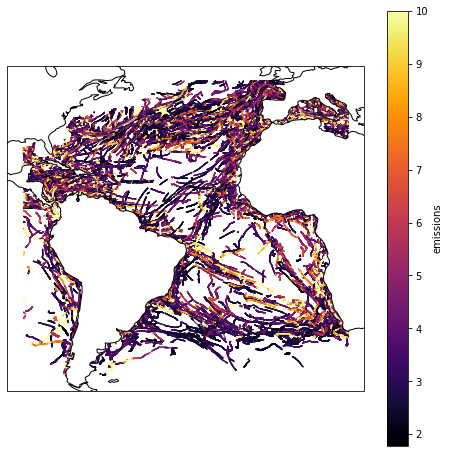

In [46]:
# here, all the trajectories are advected to their locations when the satellite passes

plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(coll.longitude, coll.latitude, c=coll.signal, cmap='inferno', s=0.05, vmax=10)
plt.colorbar(label='emissions')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='white'))

<AxesSubplot:ylabel='Frequency'>

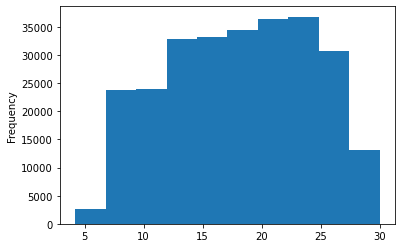

In [41]:
# as a first example, we can plot the distribution of droplet radii retrieved
# have a play around with the distributions of data
coll.r_eff.plot.hist()

In [35]:
# mod_lr.coords()[0].data.max()

In [36]:
# mod_lr.coords()[1].data.max()

In [37]:
# data=mod_lr
# window=[[mod_lr.coords()[0].data.min(), mod_lr.coords()[0].data.max()],[mod_lr.coords()[1].data.min(), mod_lr.coords()[1].data.max()]]
# plomo=data.aggregate(x=[window[1][0], window[1][1], 0.05], y=[window[0][0],window[0][1], 0.05])[0].data[:,:,0]

In [38]:
# plt.imshow(plomo, vmax=2000)
# plt.colorbar()